# Estimating prediction intervals of time series forecast with EnbPI

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scikit-learn-contrib/MAPIE/blob/add-ts-notebooks/notebooks/regression/ts-changepoint.ipynb)

This example uses `mapie.time_series_regression.MapieTimeSeriesRegressor` to estimate
prediction intervals associated with time series forecast. It follows Xu \& Xie (2021).
We use here the Victoria electricity demand dataset used in the book
"Forecasting: Principles and Practice" by R. J. Hyndman and G. Athanasopoulos.
The electricity demand features daily and weekly seasonalities and is impacted
by the temperature, considered here as a exogeneous variable.
A Random Forest model is already fitted on data. The hyper-parameters are
optimized with a `sklearn.model_selection.RandomizedSearchCV` using a
sequential `sklearn.model_selection.TimeSeriesSplit` cross validation,
in which the training set is prior to the validation set.
The best model is then feeded into
`mapie.time_series_regression.MapieTimeSeriesRegressor` to estimate the
associated prediction intervals. We compare four approaches: with or without
``partial_fit`` called at every step. 

In [1]:
install_mapie = True
if install_mapie:
    !pip install "git+https://github.com/scikit-learn-contrib/MAPIE.git@add-ts-notebooks"

  Cloning https://github.com/scikit-learn-contrib/MAPIE.git (to revision add-ts-notebooks) to /private/var/folders/x8/h56vcw5j0kg4tpm3h3z1gzyh0000gn/T/pip-req-build-ybnd6x_w
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-learn-contrib/MAPIE.git /private/var/folders/x8/h56vcw5j0kg4tpm3h3z1gzyh0000gn/T/pip-req-build-ybnd6x_w
  Running command git checkout -b add-ts-notebooks --track origin/add-ts-notebooks
  Switched to a new branch 'add-ts-notebooks'
  Branch 'add-ts-notebooks' set up to track remote branch 'add-ts-notebooks' from 'origin'.
  Resolved https://github.com/scikit-learn-contrib/MAPIE.git to commit 06009bf4c111f976cff4fd34306d23067f56b010
  Preparing metadata (setup.py) ... done
  Created wheel for MAPIE: filename=MAPIE-0.3.2-py3-none-any.whl size=55385 sha256=3f2962d8e0e980a7c4626f2b85143a5dbf5ddf4af0ff11ee8f1947f6bb22f27f
  Stored in directory: /private/var/folders/x8/h56vcw5j0kg4tpm3h3z1gzyh0000gn/T/pip-ephem-wheel-cache-z5_z8qri/wheels/1

In [2]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.subsample import BlockBootstrap
from mapie.time_series_regression import MapieTimeSeriesRegressor

%reload_ext autoreload
%autoreload 2
warnings.simplefilter("ignore")

## 1. Load input data and feature engineering

In [3]:
url_file = "https://raw.githubusercontent.com/scikit-learn-contrib/MAPIE/master/examples/data/demand_temperature.csv"
demand_df = pd.read_csv(
    url_file, parse_dates=True, index_col=0
)

demand_df["Date"] = pd.to_datetime(demand_df.index)
demand_df["Weekofyear"] = demand_df.Date.dt.isocalendar().week.astype("int64")
demand_df["Weekday"] = demand_df.Date.dt.isocalendar().day.astype("int64")
demand_df["Hour"] = demand_df.index.hour
n_lags = 5
for hour in range(1, n_lags):
    demand_df[f"Lag_{hour}"] = demand_df["Demand"].shift(hour)


## 2. Train/validation/test split

In [4]:
num_test_steps = 24 * 7
demand_train = demand_df.iloc[:-num_test_steps, :].copy()
demand_test = demand_df.iloc[-num_test_steps:, :].copy()
features = ["Weekofyear", "Weekday", "Hour", "Temperature"] 
features += [f"Lag_{hour}" for hour in range(1, n_lags)]

X_train = demand_train.loc[
    ~np.any(demand_train[features].isnull(), axis=1), features
]
y_train = demand_train.loc[X_train.index, "Demand"]
X_test = demand_test.loc[:, features]
y_test = demand_test["Demand"]

Text(0, 0.5, 'Hourly demand (GW)')

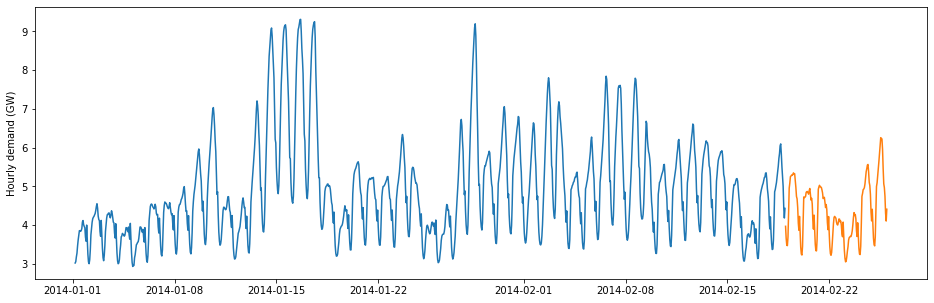

In [5]:
plt.figure(figsize=(16, 5))
plt.plot(y_train)
plt.plot(y_test)
plt.ylabel("Hourly demand (GW)")

## 3. Optimize the base estimator

In [6]:
model_params_fit_not_done = False
if model_params_fit_not_done:
    # CV parameter search
    n_iter = 100
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random_state = 59
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model,
        param_distributions=rf_params,
        n_iter=n_iter,
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    model = cv_obj.best_estimator_
else:
    # Model: Random Forest previously optimized with a cross-validation
    model = RandomForestRegressor(
        max_depth=10, n_estimators=50, random_state=59)

## 4. Estimate prediction intervals on the test set

In [7]:
alpha = 0.05
gap = 1
cv_mapiets = BlockBootstrap(
    n_resamplings=100, length=48, overlapping=True, random_state=59
)
mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)

### Without partial fit

In [8]:
print("EnbPI, with no partial_fit, width optimization")
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    X_test, alpha=alpha, ensemble=True, beta_optimize=True
)
coverage_npfit = regression_coverage_score(
    y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(
    y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)

EnbPI, with no partial_fit, width optimization


### With partial fit

In [9]:
print("EnbPI with partial_fit, width optimization")
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_pfit[step:step + gap],
        y_pis_pfit[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True
    )
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(
    y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)

EnbPI with partial_fit, width optimization


## V. Plot estimated prediction intervals on test set

In [10]:
y_preds = [y_pred_npfit, y_pred_pfit]
y_pis = [y_pis_npfit, y_pis_pfit]
coverages = [coverage_npfit, coverage_pfit]
widths = [width_npfit, width_pfit]

In [11]:
def plot_forecast(y_train, y_test, y_preds, y_pis, coverages, widths):
    fig, axs = plt.subplots(
        nrows=2, ncols=1, figsize=(16, 12), sharey="row", sharex="col"
    )
    for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
        ax.set_ylabel("Hourly demand (GW)")
        ax.plot(y_train[int(-len(y_test)/2):], lw=2, label="Training data", c="C0")
        ax.plot(y_test, lw=2, label="Test data", c="C1")

        ax.plot(
            y_test.index, y_preds[i], lw=2, c="C2", label="Predictions"
        )
        ax.fill_between(
            y_test.index,
            y_pis[i][:, 0, 0],
            y_pis[i][:, 1, 0],
            color="C2",
            alpha=0.2,
            label="MapieTimeSeriesRegressor PIs",
        )
        ax.set_title(
            f"EnbPI, {w} partial_fit.\n"
            f"Coverage:{coverages[i]:.3f}  Width:{widths[i]:.3f}"
        )
        ax.legend()
    plt.show()

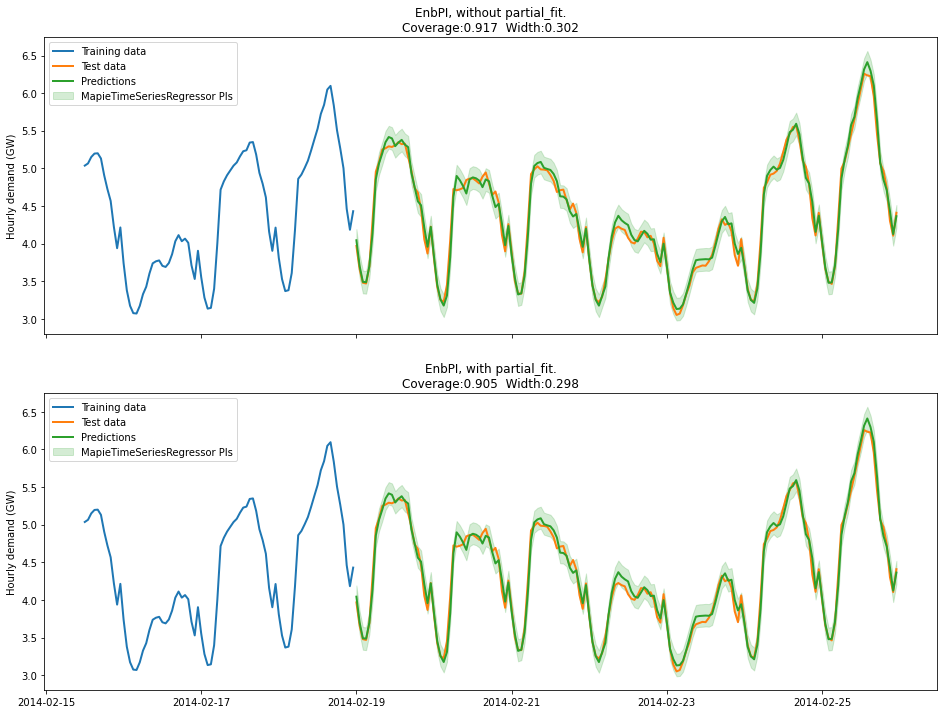

In [12]:
plot_forecast(y_train, y_test, y_preds, y_pis, coverages, widths)

## VI. Forecast on test dataset with change point

We will now see how MAPIE adapts its prediction intervals when a brutal changepoint arises in the test set. To simulate this, we will artificially decrease the electricity demand by 2 GW in the test set, aiming at simulating an effect, such as blackout or lockdown due to a pandemic, that was not taken into account by the model during its training. 

### Corrupt the dataset

In [13]:
demand_df_corrupted = demand_df.copy()
demand_df_corrupted.Demand.iloc[-int(num_test_steps/2):] -= 2

In [14]:
n_lags = 5
for hour in range(1, n_lags):
    demand_df[f"Lag_{hour}"] = demand_df["Demand"].shift(hour)
demand_train_corrupted = demand_df_corrupted.iloc[:-num_test_steps, :].copy()
demand_test_corrupted = demand_df_corrupted.iloc[-num_test_steps:, :].copy()

X_train = demand_train_corrupted.loc[
    ~np.any(demand_train_corrupted[features].isnull(), axis=1), features
]
y_train = demand_train_corrupted.loc[X_train.index, "Demand"]
X_test = demand_test_corrupted.loc[:, features]
y_test = demand_test_corrupted["Demand"]

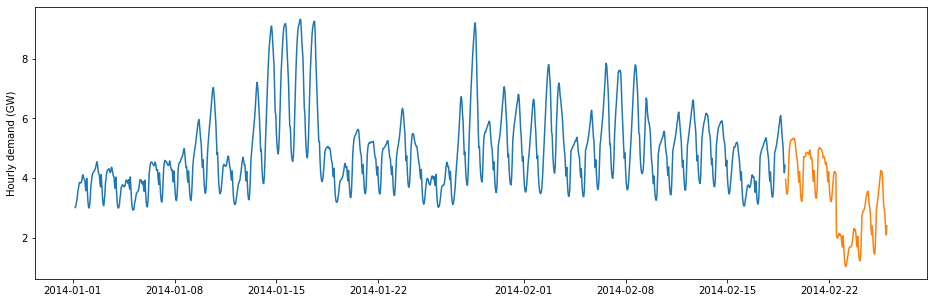

In [15]:
plt.figure(figsize=(16, 5))
plt.ylabel("Hourly demand (GW)")
plt.plot(y_train)
plt.plot(y_test)

### Prediction intervals without partial fit

In [16]:
print("EnbPI, with no partial_fit, width optimization")
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    X_test, alpha=alpha, ensemble=True, beta_optimize=True
)
coverage_npfit = regression_coverage_score(
    y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(
    y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)

EnbPI, with no partial_fit, width optimization


### Prediction intervals with partial fit

In [17]:
print("EnbPI with partial_fit, width optimization")
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
conformity_scores_pfit, lower_quantiles_pfit, higher_quantiles_pfit = [], [], []
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_pfit[step:step + gap],
        y_pis_pfit[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True
    )
    conformity_scores_pfit.append(mapie_enbpi.conformity_scores_)
    lower_quantiles_pfit.append(mapie_enbpi.lower_quantiles_)
    higher_quantiles_pfit.append(mapie_enbpi.higher_quantiles_)
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(
    y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)

EnbPI with partial_fit, width optimization


### Plot estimated prediction intervals on test set

In [18]:
y_preds = [y_pred_npfit, y_pred_pfit]
y_pis = [y_pis_npfit, y_pis_pfit]
coverages = [coverage_npfit, coverage_pfit]
widths = [width_npfit, width_pfit]

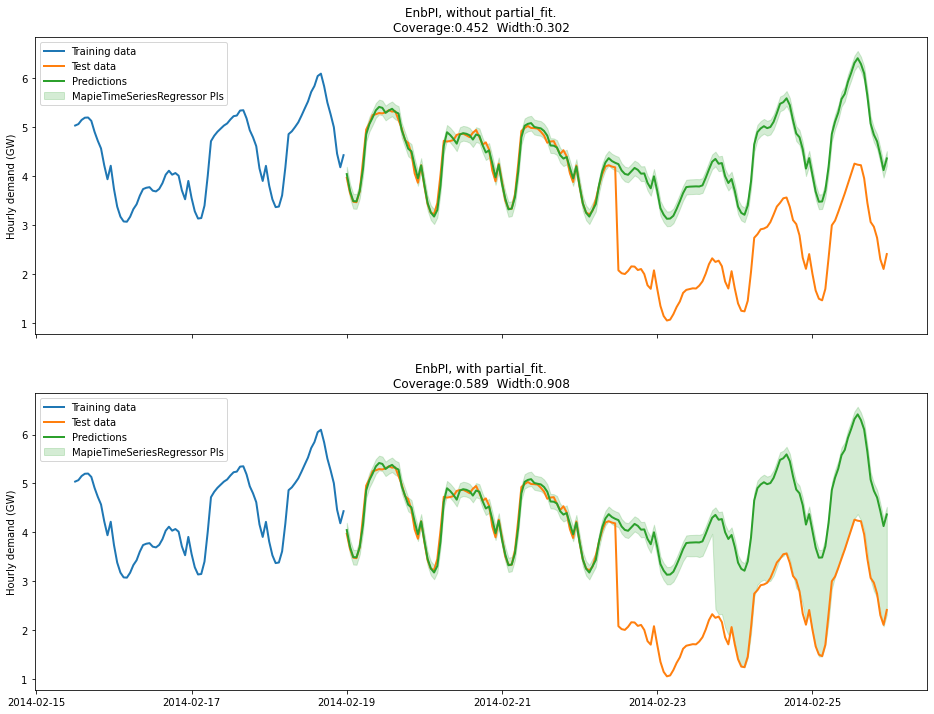

In [19]:
plot_forecast(y_train, y_test, y_preds, y_pis, coverages, widths)

In [20]:
window = 24
rolling_coverage_pfit, rolling_coverage_npfit = [], []
for i in range(window, len(y_test), 1):
    rolling_coverage_pfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_pfit[i-window:i, 0, 0], y_pis_pfit[i-window:i, 1, 0]
        )
    )
    rolling_coverage_npfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_npfit[i-window:i, 0, 0], y_pis_npfit[i-window:i, 1, 0]
        )
    )

### Marginal coverage on a 24-hour rolling window of prediction intervals

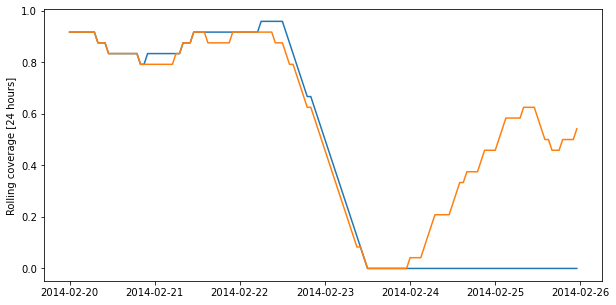

In [21]:
plt.figure(figsize=(10, 5))
plt.ylabel(f"Rolling coverage [{window} hours]")
plt.plot(y_test[window:].index, rolling_coverage_npfit, label="Without update of residuals")
plt.plot(y_test[window:].index, rolling_coverage_pfit, label="With update of residuals")

### Temporal evolution of the distribution of residuals used for estimating prediction intervals

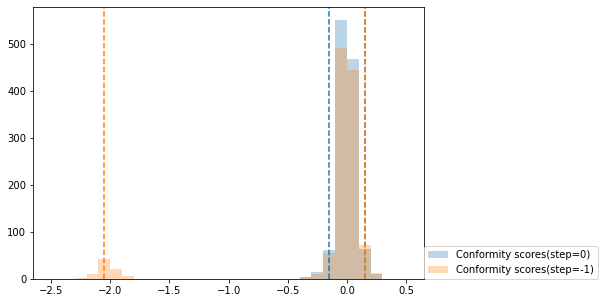

In [22]:
plt.figure(figsize=(7, 5))
for i, j in enumerate([0, -1]):
    plt.hist(conformity_scores_pfit[j], range=[-2.5, 0.5], bins=30, color=f"C{i}", alpha=0.3, label=f"Conformity scores(step={j})")
    plt.axvline(lower_quantiles_pfit[j], ls="--", color=f"C{i}")
    plt.axvline(higher_quantiles_pfit[j], ls="--", color=f"C{i}")
plt.legend(loc=[1, 0])